# ASPA-UHWRRC Wx data processing 


This repository is the cloud-home of the UH-ASPA weather station project, which is currently mainteined by C. Shuler (UH) and M. Erickson (ASPA)

The script below is designed to process weather station data from 6 full weather stations and one solar radiation station on Tutuila into useful  information. For metadata and all other available information regarding these stations please see the Docs folder in this repository.

This script is a work in progress. It is currently the most up to date version of a program designed to process raw .csv files exported from Hoboware software, but is is subject to change, revision, or removal at the developers discression.

No guarentee is made regarding the quality or accuracy of these data. No QA QC procedures have been applied to these data except for what is explicitly shown in the cells below.


note that to use this code all data files MUST: 
- start with the proper name of the station followed by a space, - or an _
- be in the data format of the existing spectrum or campbell files (see raw data files for examples)
- data must all be on "sheet1" if in an excel file


In [1]:
# make the screen bigger!

from IPython.display import display, HTML

display(HTML(data="""   <style>     div#notebook-container    { width: 100%; }     div#menubar-container     { width: 85%; }     div#maintoolbar-container { width: 99%; } </style>
"""))

# import all our libraries (if this cell throws an error you may need to reinstall a library)
import os
import pandas as pd
import shutil   
import re
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats

%run Functions/Funcs.py

%matplotlib notebook

# some path managment here
homedir = os.getcwd()

# paths for files to come from or go to
datapath = "Raw_data"
if not os.path.exists(os.path.join('.', 'workspace//Data2')):   # workspace path
    os.makedirs(os.path.join('.', 'workspace//Data2'))   
if not os.path.exists(os.path.join('.', 'workspace//Data3')):   # workspace path
    os.makedirs(os.path.join('.', 'workspace//Data3')) 
workspace = os.path.join('.', 'workspace')
datapath2 = os.path.join('.', 'workspace//Data2')
processraw_path = os.path.join('.', 'workspace//Data3')


headings = ['DateTime', 'SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

### Convert anything that is in a xls format to a csv format  
(kind of long run time)

In [2]:
files1 = os.listdir(datapath) # make a list of all the files in the directory
for i in files1: 
    try: 
        if i.endswith('.xlsx'):
            data_xls = pd.read_excel(os.path.join(datapath, i),  index_col=0)  # read  xlsx to memory
            nam = i.split(".")[0]                                  # remove the .xls
            data_xls.to_csv(os.path.join(datapath2,  nam+'.csv'), encoding='utf-8')       # turn xlsx to csv
                       
        elif i.endswith(".csv"):
            shutil.copy(os.path.join(datapath, i), datapath2)
    except:  
        print("Problem_with   - {}".format(i))

### Process raw datafiles

In [3]:
# starat by opening up each file and taking out trash header rows 
p = re.compile('time', re.IGNORECASE)  # string to look for is anything with "time" in it for taking out trash headings

csvpile = os.listdir(datapath2)  #  List all the raw data files
for c in csvpile:
    try: 
        x_new =pd.DataFrame(columns = headings)     # blank dataframe for later
        filr = os.path.join(datapath2, c)             # select file
        with open(filr, 'r') as f_in:                 # open file 
            data = f_in.read().splitlines(True)       # temporary object

        for i in range(0,6):
            matcher = p.search(data[i])             # find the row that has the word time in it
            if matcher:
                rows2skip = i                       # ID the number of rows to skip to make the time row the header row
        x = pd.read_csv(filr, skiprows=rows2skip)

        x.columns = x.columns.str.strip()                  # remove any whitespace in the collumn headdings 

    # this block standardizes all the columns to the same names
        for i in x.columns:
            if i in ("TIMESTAMP","Timestamp", "Date and Time" ):
                x =  x.rename(columns={i: "DateTime"} )
            if i in ("TMP" , "Air Temp (F)", "AirTF_Avg"):
                x =  x.rename(columns={i: "TMP_F"} )
            if i in ("HMD", "RH", "Relative Humidity"):
                x =  x.rename(columns={i: "HMD_pct"} )
            if i in ("SRD", "Solar Rad (W_AVG)", "SlrMJ_Tot"):
                x =  x.rename(columns={i: "SRD_wpm2"} )
            if i in ("RNF", "Rain_in_Tot", "Rain (in)"):
                x =  x.rename(columns={i: "RNF_in"} )
            if i in ("WND", "WindDir_D1_WVT", "Wind Direction (D1)"):
                x =  x.rename(columns={i: "WND_deg"} )       
            if i in ("WNS", "Wind Speed (MPH)", "WS_mph_S_WVT"):
                x =  x.rename(columns={i: "WNS_mph"} )  

    # This block takes out unwanted headings and resets index
        try:
            for j in headings:
                x_new[j] = x[j]                                    # select only the headings we want
        except:                                                    # this except pass keeps it from hanging up where there are missing columns like in the ASPA SR station   
            pass
        x_new = x_new.reset_index(drop=True)                       # reset the row index to start from 0

    #this names the data key based on its first and last date (if there is a repeat file it will not make a repeat data entry)
        c = c.replace("-", " "); c = c.replace("_", " ")                # this takes any dashes and underscores turns them to spaces so that the first word can be used for the name even is there is a dash

        x_new['DateTime'] = pd.to_datetime(x_new['DateTime'], errors='coerce')  # string date to real date
    # note: some of the time stamps from the stations are not perfectily on 15 mins, this rounds to the nearest 15    

        x_new['DateTime'] = x_new['DateTime'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))

        key_name = c.split(" ")[0] +'_'+ str(x_new['DateTime'].iloc[0]).split(" ")[0] +'_to_'+str(x_new['DateTime'].iloc[-1]).split(" ")[0]

        x_new.to_csv(os.path.join(processraw_path, key_name+'.csv'))
        # note: this step is where duplicate files will dissapear as they will be named the exact same thing and then ocerwitten by the loop

    except:  
        print("Problem_with   -   "+c)

### Take formatted csv files and turn them into a dictionary 
Each file is keyed according to its station - start date - and end date

In [4]:
files3 = os.listdir(processraw_path)
All_data = {}

for i in files3:
    try:
        file_name = i.split(".")[0]
        datas = pd.read_csv(os.path.join(processraw_path, i), parse_dates=['DateTime'])
        All_data[file_name] = datas   # all data now houses all the formatted files in a dictionary form use len(All_data.keys()) to check number of files included
    except:  
        print("Problem_with   -   "+i)

### Take all the files and separates them all out into individual dictionaries based on each station


In [5]:
listos = list(All_data.keys())   # list of each file in the directory

headings_no_date = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

AasuWx = {}                      # empty dictionaries for each station, add more of these to add statoins
AlavaWx = {}                     # note these are dictionaries of each individual file arranged by station name, thus these are a bunch of individual files
PoloaWx = {}
VaipitoWx = {}
FagaituaWx = {}
AfonoWx = {}
ASPAsolarWx ={}

try:
    r = re.compile('[Aa]asu')                       # find things that have this substring in them
    Aasu_files = list(filter(r.match, listos))      # from the list of all the files that exist  (listos)
except: 
    print("Problem_matching - Aasu")
    
try:
    for a in Aasu_files:                            # for each of those files add it to the dictionary one by one    
        AasuWx[a] = All_data[a]                     # this line populates the file dictionaries
        for h in headings_no_date:
            AasuWx[a][h]=AasuWx[a][h].astype(float)                                  # for some reason the data was coming is as strings so have to convert it to floats...
    AasuMaster = pd.concat(AasuWx.values()).drop_duplicates(subset='DateTime')  # This is now a dataframe for the station (stick all the files together into one, and drop any overlap)
    AasuMaster = AasuMaster.sort_values('DateTime')                             # This now sorts in date order
    del AasuMaster['Unnamed: 0']               # old index turned into a column, gotta delete it. 
    AasuMaster = AasuMaster.reset_index(drop=True)          #Reset index to integers (note! this can be turned off to diagnose strange conoctation issues, otherwise you moght not know when different files stick together weird)
except: 
    print("Problem_with - "+a)


try:
    r = re.compile('[Aa]lava')
    Alava_files = list(filter(r.match, listos))  
except: 
    print("Problem_matching - Alava") 
    
try:
    for b in Alava_files:
        AlavaWx[b] = All_data[b]
        for h in headings_no_date:
            AlavaWx[b][h]=AlavaWx[b][h].astype(float) 
    AlavaMaster = pd.concat(AlavaWx.values()).drop_duplicates(subset='DateTime')  
    AlavaMaster = AlavaMaster.sort_values('DateTime')  
    del AlavaMaster['Unnamed: 0']
    AlavaMaster = AlavaMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+b)
   
    
try:  
    r = re.compile('[Pp]oloa')
    Poloa_files = list(filter(r.match, listos))  
except: 
    print("Problem_matching - Poloa") 

try:
    for c in Poloa_files:
        PoloaWx[c] = All_data[c] 
        for h in headings_no_date:
            PoloaWx[c][h]=PoloaWx[c][h].astype(float) 
    PoloaMaster = pd.concat(PoloaWx.values()).drop_duplicates(subset='DateTime')  
    PoloaMaster = PoloaMaster.sort_values('DateTime') 
    del PoloaMaster['Unnamed: 0']
    PoloaMaster = PoloaMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+c)
   
        
try:   
    r = re.compile('[Vv]aipito')
    Vaipito_files = list(filter(r.match, listos)) 
except: 
    print("Problem_matching - vaipito") 
    
    
try:
    for d in Vaipito_files:
        VaipitoWx[d] = All_data[d]
        for h in headings_no_date:
            VaipitoWx[d][h]=VaipitoWx[d][h].astype(float) 
    VaipitoMaster = pd.concat(VaipitoWx.values()).drop_duplicates(subset='DateTime')  
    VaipitoMaster = VaipitoMaster.sort_values('DateTime') 
    del VaipitoMaster['Unnamed: 0']
    VaipitoMaster = VaipitoMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+d)
    

try:
    r = re.compile('[Ff]agaitua')
    Fagaitua_files = list(filter(r.match, listos))   
except: 
    print("Problem_matching - Fagaitua")  
    
try:
    for e in Fagaitua_files:
        FagaituaWx[e] = All_data[e]
        for h in headings_no_date:
            FagaituaWx[e][h]=FagaituaWx[e][h].astype(float) 
    FagaituaMaster = pd.concat(FagaituaWx.values()).drop_duplicates(subset='DateTime')  
    FagaituaMaster = FagaituaMaster.sort_values('DateTime') 
    del FagaituaMaster['Unnamed: 0']
    FagaituaMaster = FagaituaMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+e)
    

try:
    r = re.compile('[Aa]fono')                       
    Afono_files = list(filter(r.match, listos)) 
except: 
    print("Problem_matching - Afono")
    
try:
    for f in Afono_files:                            
        AfonoWx[f] = All_data[f]
        for h in headings_no_date:
            AfonoWx[f][h]=AfonoWx[f][h].astype(float)  
    AfonoMaster = pd.concat(AfonoWx.values()).drop_duplicates(subset='DateTime')  
    AfonoMaster = AfonoMaster.sort_values('DateTime')
    del AfonoMaster['Unnamed: 0']
    AfonoMaster = AfonoMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+f)

    
try:
    r = re.compile('ASPA')                       
    ASPAsolar_files = list(filter(r.match, listos))   
except: 
    print("Problem_matching - ASPA")

try:
    for g in ASPAsolar_files:                            
        ASPAsolarWx[g] = All_data[g]
        for h in headings_no_date:
            ASPAsolarWx[g][h]=ASPAsolarWx[g][h].astype(float)  
    ASPAsolarMaster = pd.concat(ASPAsolarWx.values()).drop_duplicates(subset='DateTime')  
    ASPAsolarMaster = ASPAsolarMaster.sort_values('DateTime')
    del ASPAsolarMaster['Unnamed: 0']
    ASPAsolarMaster = ASPAsolarMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+g)

    
# FYI now each (station)Master is a dataframe with the data from each station stuck together and ordered by date. 

# QAQC routines

In [6]:
# paramaters to cut data 
start_recording = pd.to_datetime('2015-07-21 12:00:00', errors='coerce')  # this is the first date that data can exist, there were some eronious dates in some files


# these are the threshhold values to QA-QC for, these are arbitrarily chosen right now, probably should get a reference for choosing these.
Tmax = 105
Tmin = 50
Hmin = 30
Hmax = 100
RNFmax = 4
WNDir_min = 0
WNDir_max = 360
WNGust_min = 0
WNGust_max = 70
WNSpeed_min = 0
WNSpeed_max = 50

QAmasters = {}
masters = {'AasuWx': AasuMaster, 'AlavaWx': AlavaMaster, 'PoloaWx': PoloaMaster,'VaipitoWx': VaipitoMaster, 'FagaituaWx':FagaituaMaster, 'AfonoWx':AfonoMaster, 'ASPAsolarWx':ASPAsolarMaster} # make a dictionary of all the master data files

# this form deletes all the ROWS with eronious data, needs to be in a separate loop from the one below 
for i in masters:
    masters[i] = masters[i][masters[i]['DateTime'] > start_recording]    # remove eronious dates  (this form deletes all the ROWS,)

# this form deletes individual data points    
for i in masters:
    QAmasters[i] = masters[i].copy(deep=True)    # here needed to avoid set copy slice warning...

# this form deletes individual data points   
for i in QAmasters: 
    QAmasters[i]['TMP_F'] =  QAmasters[i].loc[QAmasters[i].TMP_F < Tmax, 'TMP_F'] # the "QAmasters[i].TMP < Tmax" object is the mask (a bool of values that meet the criteria)
    QAmasters[i]['TMP_F'] =  QAmasters[i].loc[QAmasters[i].TMP_F > Tmin, 'TMP_F'] # the object after the > or < operator is the paramater set above
    QAmasters[i]['HMD_pct'] =  QAmasters[i].loc[QAmasters[i].HMD_pct < Hmax, 'HMD_pct'] 
    QAmasters[i]['HMD_pct'] =  QAmasters[i].loc[QAmasters[i].HMD_pct > Hmin, 'HMD_pct']
    QAmasters[i]['RNF_in'] =  QAmasters[i].loc[QAmasters[i].RNF_in < RNFmax, 'RNF_in']
    QAmasters[i]['WND_deg'] =  QAmasters[i].loc[QAmasters[i].WND_deg < WNDir_max, 'WND_deg'] 
    QAmasters[i]['WND_deg'] =  QAmasters[i].loc[QAmasters[i].WND_deg >= WNDir_min, 'WND_deg']
    QAmasters[i]['WNS_mph'] =  QAmasters[i].loc[QAmasters[i].WNS_mph < WNSpeed_max, 'WNS_mph'] 
    QAmasters[i]['WNS_mph'] =  QAmasters[i].loc[QAmasters[i].WNS_mph >= WNSpeed_min, 'WNS_mph']
    
    QAmasters[i] = QAmasters[i][pd.notnull(QAmasters[i]['DateTime'])]        # drop any rows that dint have a date value

# QAQC remove data blocks where we know data is trash 
-  Generally these will be documented in the station logs, though visual inspection of the data will also be useful to ID crap data zones
-  When found the start, end, station and parameter to remove should be documented in 'Wx_data_to_cut.csv'

In [7]:
cut_blocks = pd.read_csv('Wx_data_to_cut.csv')
cut_blocks['Start'] = pd.to_datetime(cut_blocks['Start'] , errors='coerce')  # string date to real date
cut_blocks['End'] = pd.to_datetime(cut_blocks['End'] , errors='coerce')  # string date to real date


for index, row in cut_blocks.iterrows():    # iterate over each bad data block,
    start = row['Start']   # ID start, end, etc...
    end = row['End']        
    site = row['Station']+'Wx'
    if row['Param'] == 'All':            # if all data needs to be removed should be qualified with all
#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
        baddatelist = []   
        for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval       
            baddatelist.append(dt)                              # stick each interval object onto a list 
        bad_rows = QAmasters[site]['DateTime'].isin(baddatelist)     # boolian of the block that needs cuttting 
        QAmasters[site].loc[bad_rows] = np.nan                            # all data gets cut (NaN)
        
    else:                                # if only one parameter needs cutting 
        paramater = row['Param']         # ( if there are more than 1 but less than all, should put in additional row in Wx_data_to_cut)
#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
        baddatelist = []   
        for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval       
            baddatelist.append(dt)                              # stick each interval object onto a list 
        bad_rows = QAmasters[site]['DateTime'].isin(baddatelist)
        QAmasters[site].loc[bad_rows, paramater] = np.nan                 # just cut individual value

# Plotting 
makes individual plots to see

C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


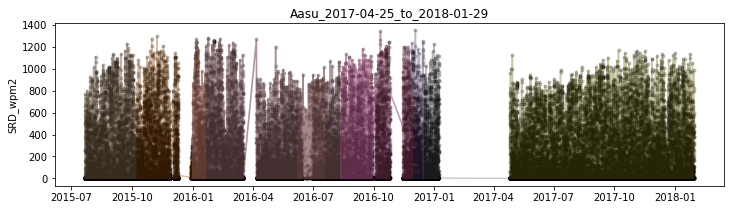

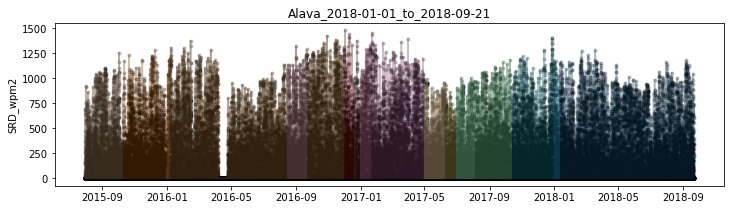

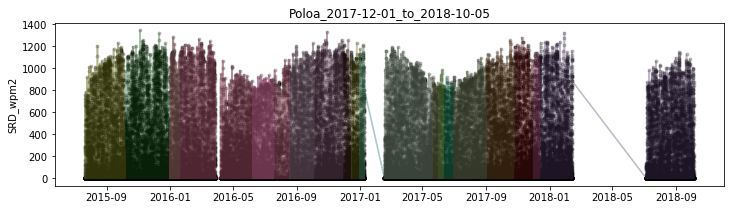

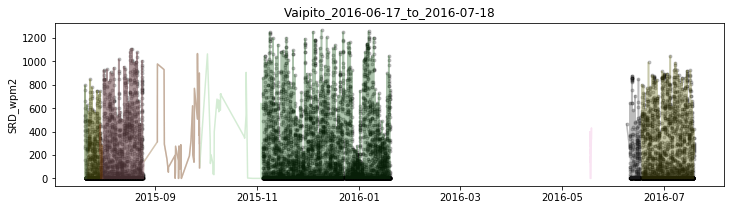

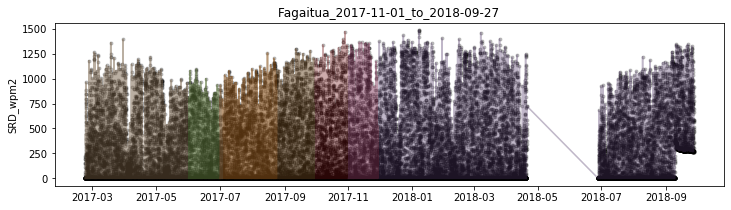

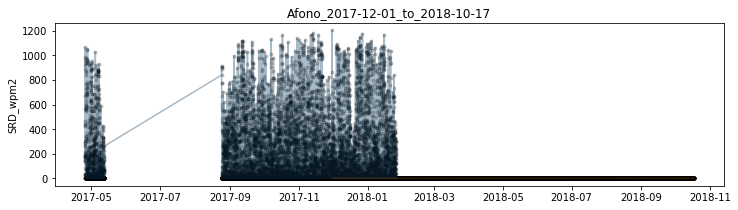

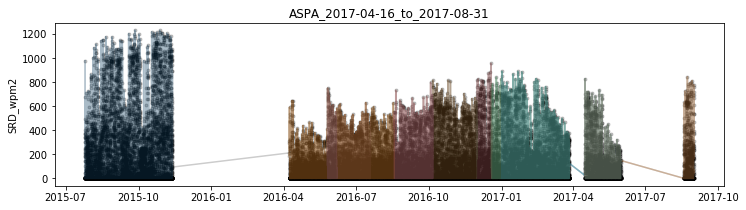

In [8]:
# ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']      options
param = 'SRD_wpm2'

Da_list = ['AasuWx', 'AlavaWx', 'PoloaWx', 'VaipitoWx', 'FagaituaWx', 'AfonoWx', 'ASPAsolarWx']                                                             # remember the Wx dicts are groups of individual files...
stations = {'AasuWx':AasuWx, 'AlavaWx':AlavaWx, 'PoloaWx':PoloaWx, 'VaipitoWx':VaipitoWx, 'FagaituaWx':FagaituaWx, 'AfonoWx':AfonoWx, 'ASPAsolarWx':ASPAsolarWx}        # stations is a dictionary of dictionaries
#masters = {'AasuWx': AasuMaster, 'AlavaWx': AlavaMaster, 'PoloaWx': PoloaMaster,'VaipitoWx': VaipitoMaster, 'FagaituaWx':FagaituaMaster, 'AfonoWx':AfonoMaster} # this is a dictionary of all master data files
#note this is confusing, but the masters dictionary is a dictionary of the master_dataframes, has nothing to do with the groups (dicts) of individual files (Wx dictionaries) 
#but needs same name to plot within the loop.  The masters dictionary is remade below with keys that do not have that Wx ending

# plot the master files in black
try:
    for t in Da_list: 
        fig = plt.figure(figsize=(12, 3))
        ax1 = plt.axes()
        files = list(stations[t].keys())
        ax1.plot(QAmasters[t]['DateTime'], QAmasters[t][param], alpha = .2, color='k', marker='.', label='master' )

        for i in files:    
            ax1.set_ylabel(param, color='k')
            plt.plot(stations[t][i]['DateTime'], stations[t][i][param], alpha = .2, label=i)
            ax1.set_title(i)

        #plt.xticks(rotation=20)
       # plt.tight_layout()

        plt.show()  
except: 
    pass

# Take ALL the Wx data from all stations and puts it into one master file


In [9]:
#This takes the Stations with the dates and figures out what the first and last dates are of all data in the folder         
# Then all the data can be put together into one file based on the FULL date range

splitter = lambda x: x.split("_")   # quick function to split each key name to parts
split_list = list(map(splitter, listos)); split_list    # apply the function to the list of file name keys (makes a list of lists) 
from itertools import chain
fitlist = list(chain.from_iterable(split_list))         # takes a list of lists and truns it into a list of the items
sortlist = sorted(fitlist)                              # sort it alphabetically 
dates_list = pd.to_datetime(sortlist, errors='coerce').dropna() # string date to real date and drop all the other words
start = dates_list[0]                                   # first date in the list
end = dates_list[-1] +timedelta(days=1)                 # last date in the list plus 1 day
# note does not do anything with data, just with the date range. 

#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
Bigdatelist = []
for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval       
    Bigdatelist.append(dt)                              # stick each interval object onto a list 
labels = ['DateTime']                                  #define column name for dataframe
All_station_dates = pd.DataFrame(Bigdatelist, columns=labels)    # Make our list into a pd dataframe


Print_masters = {'Aasu': QAmasters['AasuWx'], 'Alava': QAmasters['AlavaWx'], 'Poloa': QAmasters['PoloaWx'],'Vaipito': QAmasters['VaipitoWx'], 'Fagaitua':QAmasters['FagaituaWx'], 'Afono':QAmasters['AfonoWx'], 'ASPAsolar':QAmasters['ASPAsolarWx']} # make a dictionary of all the master data files
for i in Print_masters: 
    Print_masters[i] = Print_masters[i].add_prefix(i+'_')  #Then add the prefix for the station ontoeach file
    date_col_nam = [col for col in Print_masters[i].columns if 'Date' in col]              # to effectivly merge them the prefix needs to be taken from the date. This matches any column with "date"
    Print_masters[i]= Print_masters[i].rename(columns = {str(date_col_nam[0]):'DateTime'}) # this renames that date column to DateTime plain and simple. 

#merge all the datasets into one massive dataset
All_merged = All_station_dates.merge(Print_masters['Aasu'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Alava'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Poloa'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Vaipito'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Fagaitua'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Afono'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['ASPAsolar'], how='outer', on='DateTime')

All_merged = All_merged[pd.notnull(All_merged['DateTime'])]        # drop any rows that dint have a date value

#all Merged is now the date aligned master dataset
All_merged.to_csv(os.path.join(workspace, 'QA_All_merged.csv'))

# plot individual stations, all datasets

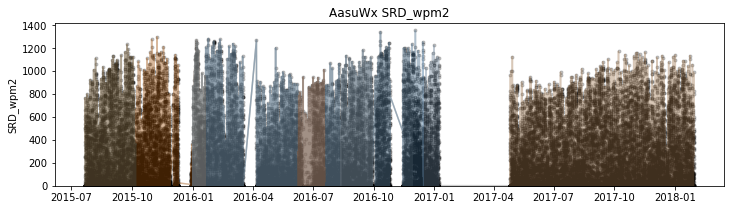

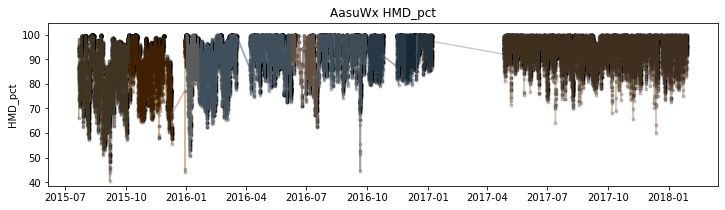

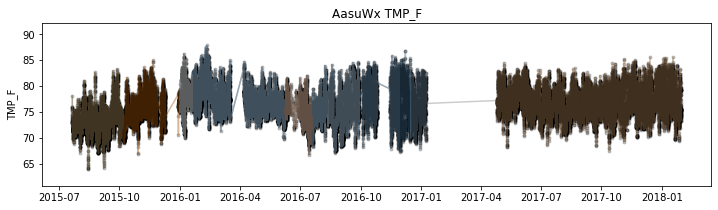

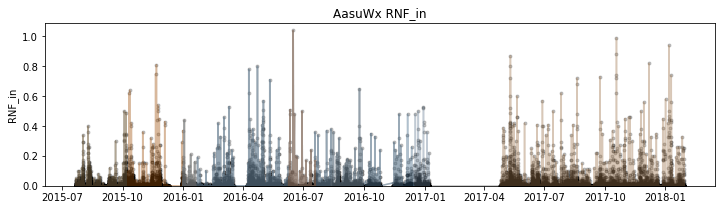

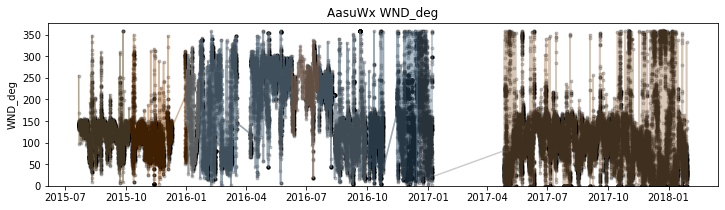

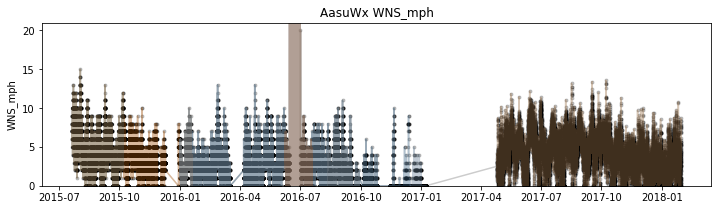

In [10]:
plt.style.use('tableau-colorblind10')       # Plot styple options, for  full list use     print plt.style.available

plot_station = 'AasuWx'    # optios ['FagaituaWx', 'ASPAsolarWx', 'AasuWx', 'PoloaWx', 'AlavaWx', 'VaipitoWx', 'AfonoWx']

for param in QAmasters[plot_station].columns[1:]:
        try:
            fig = plt.figure(figsize=(12, 3))
            ax1 = plt.axes()
            ax1.plot(QAmasters[plot_station]['DateTime'], QAmasters[plot_station][param], alpha = .2, color='k', marker='.', label='master', linestyle='-' )
            ax1.set_title(plot_station+" "+param)  
            ax1.set_ylim(min(QAmasters[plot_station][param])*.95,max(QAmasters[plot_station][param])*1.05)  
            ax1.set_ylabel(param, color='k')
            
            files = list(stations[plot_station].keys())         # for plotting indiviual downloaded files on top of datasets
            for i in files:    
                ax1.set_ylabel(param, color='k')
                plt.plot(stations[plot_station][i]['DateTime'], stations[plot_station][i][param], alpha = .25, label=i)
            
            # fig.savefig(param + '_.tif', dpi = 300 )   # commnt out if you dont want to save the plot as a file

        except:
            pass

In [17]:
# print all datasets by station as individual csvs
for i in QAmasters.keys():
    QAmasters[i].to_csv(os.path.join(workspace, '{}.csv'.format(i)))    